In [7]:
import pickle
from collections import Counter
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from DataObjs import Corpus, success_transform, confidence_transform

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
with open('Data/data_regression.p') as handle:
    raw_data = pickle.load(handle)
    
# length, lex, form -> all, p, e
# data point = (sccss_str, conf_str, ([], [], []), ([], [], []), ([], [], []))     
    
# nonoise
data_en = Corpus(raw_data[1], succs_map=success_transform, conf_map=confidence_transform)
# FTT
data_de = Corpus(raw_data[0], succs_map=success_transform, conf_map=confidence_transform) 

data_all = Corpus(dict(raw_data[0], **raw_data[1]), succs_map=success_transform, conf_map=confidence_transform)

164 164 164
88 88 88


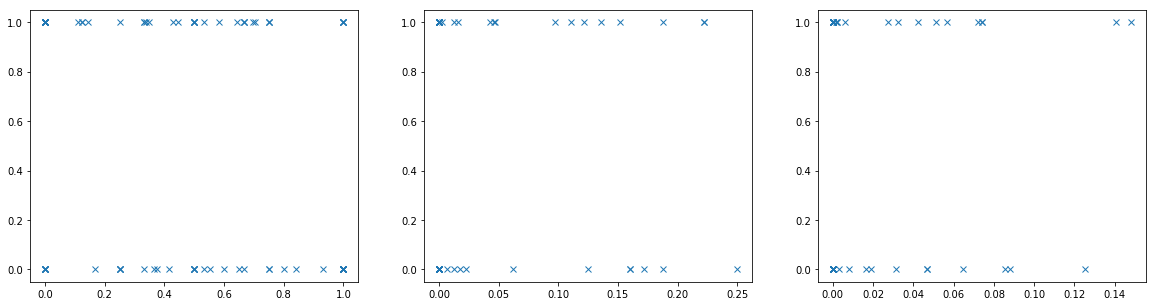

In [188]:
xs_mean = [np.mean(mv.lex_e) for mv in data_all.moves]
xs_var = [np.var(mv.lex_e) for mv in data_all.moves]

ys = [1 if y == 1 else 0 for y in data_all.get_succs()]

print len(xs_mean), len(xs_var), len(ys)

filtered_xs_mean, filtered_xs_var, filtered_ys = list(zip(*[(x_m, x_v, y) for x_m, x_v, y in zip(xs_mean, xs_var, ys) 
                                                              if (not np.isnan(x_m) and not np.isnan(x_v))]))

filtered_xs_mean, filtered_xs_var, filtered_ys = np.asarray(filtered_xs_mean), \
                                                np.asarray(filtered_xs_var), np.asarray(filtered_ys)

n_filtered = len(filtered_xs_mean)

idx = np.argsort([m*v for m, v in zip(filtered_xs_mean, filtered_xs_var)])

sorted_xs_mean = np.asarray([filtered_xs_mean[i] for i in list(idx)])
sorted_xs_var = np.asarray([filtered_xs_var[i] for i in list(idx)])
sorted_ys = np.asarray([filtered_ys[i] for i in list(idx)])

print len(sorted_xs_mean), len(sorted_xs_var), len(sorted_ys)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.plot(sorted_xs_mean, sorted_ys, 'x')
ax2.plot(sorted_xs_var, sorted_ys, 'x')
ax3.plot((sorted_xs_mean*sorted_xs_var), sorted_ys, 'x')
plt.show()


[[-0.10786848 -0.16400877 -0.8729934 ]]
[ 0.50353745]


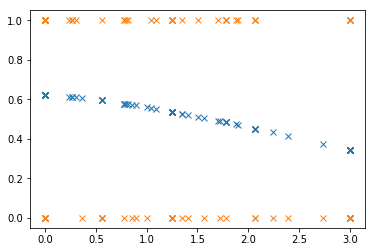

[[-0.36602957  0.         -0.10443661  0.          0.         -0.73554982]]
[ 0.47740437]


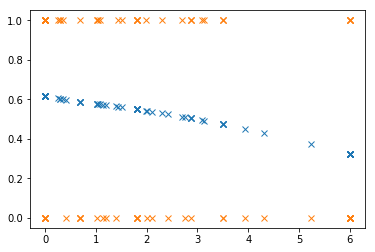

[[-0.26477774  0.          0.         -0.28100123  0.          0.          0.
   0.         -0.69257564]]
[ 0.47760553]


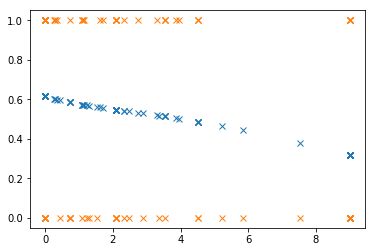

[[-0.32832773  0.          0.          0.         -0.2644569   0.          0.
   0.          0.          0.         -0.09679671 -0.55875915]]
[ 0.48292312]


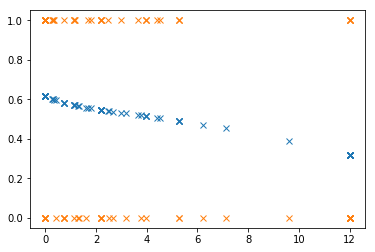

In [189]:
for d in range(2, 6):

    x_terms_mean = [sorted_xs_mean**p for p in range(1, d)]
    x_terms_mean = np.asarray(x_terms_mean).T

    x_terms_var = [sorted_xs_mean**p for p in range(1, d)]
    x_terms_var = np.asarray(x_terms_var).T

    # interactions
    x_terms_meanvar = [(x_terms_mean*x_terms_var).T[0]**p for p in range(1, d)]
    x_terms_meanvar = np.asarray(x_terms_meanvar).T

    #x_terms_meanvar = x_terms_mean*x_terms_var
    
    x_terms = np.concatenate([x_terms_mean, x_terms_var, x_terms_meanvar], axis=1)

    from sklearn.linear_model import LogisticRegressionCV

    l = LogisticRegressionCV(penalty='l1', solver='liblinear')
    l.fit(x_terms, sorted_ys)

    print l.coef_
    print l.intercept_

    predictors_together = np.sum(x_terms, axis=1)    

    fitted = l.predict_proba(x_terms)[:, 1]

    plt.plot(predictors_together, fitted, 'x')
    plt.plot(predictors_together, sorted_ys, 'x')
    plt.show()

In [191]:
# model tests
# -> likelihood-ratio test for 
# H0 := the tested predictor is not necessary; H_alt := the tested predictor achieves significantly better fit
# justification: none of the parameters of the model are unknown (the parameters are the coefficients of the terms), 
# so by the Neyman-Pearson, likelihood-ratio has the greatest power (P(reject H0| H1 is true))

def get_likeli_dof(preds, depends):
    l = LogisticRegressionCV(penalty='l1', solver='liblinear')
    l.fit(preds, depends)
    model_class_probs = l.predict_log_proba(preds)
    model_likeli = sum([row[y] for row, y in zip(model_class_probs, depends)])
    dof = preds.shape[1]+1 # +1 for the intercept
    return model_likeli, dof


# first null model has only intercept
cs = Counter(sorted_ys)
prev_likeli = sum([np.log(cs[y]/float(n_filtered)) for y in sorted_ys])
prev_dof = 1
for d in range(2, 6):
    x_terms_mean = [sorted_xs_mean**p for p in range(1, d)]
    x_terms_mean = np.asarray(x_terms_mean).T

    x_terms_var = [sorted_xs_var**p for p in range(1, d)]
    x_terms_var = np.asarray(x_terms_var).T

    # interactions
    x_terms_meanvar = [(x_terms_mean*x_terms_var).T[0]**p for p in range(1, d)]
    x_terms_meanvar = np.asarray(x_terms_meanvar).T
    #x_terms_meanvar = x_terms_mean*x_terms_var

    x_terms = np.concatenate([x_terms_mean, x_terms_var, x_terms_meanvar], axis=1)
    
    cur_likeli, cur_dof = get_likeli_dof(x_terms, sorted_ys)
    
    likelihood_ratio = -2*(prev_likeli - cur_likeli)
    p = stats.chi2(cur_dof).pdf(likelihood_ratio)
    # p is zero if no increase in likelihood 
    print 'current degree:', d-1, 'likelihood_ratio', likelihood_ratio, 'p-value', p, '-> reject null:', p < 0.05
    prev_likeli = cur_likeli
    prev_dof = cur_dof

current degree: 1 likelihood_ratio 4.57589170897 p-value 0.116084300101 -> reject null: False
current degree: 2 likelihood_ratio 0.138789024689 p-value 0.00017806106337 -> reject null: True
current degree: 3 likelihood_ratio 0.151526474733 p-value 6.36340114785e-07 -> reject null: True
current degree: 4 likelihood_ratio 0.122060525462 p-value 3.41778122397e-10 -> reject null: True
